In [1]:
import numpy as np

In [2]:
numSeeds = 24
radius = 100
seeds = radius * np.random.random((numSeeds, 2))
print("seeds:\n", seeds)
print("BBox Min:", np.amin(seeds, axis=0),"Bbox Max: ", np.amax(seeds, axis=0))

seeds:
 [[98.41302626 13.15359524]
 [44.77178817 58.28480009]
 [74.84505412 54.95533945]
 [57.82563202 46.67033345]
 [70.79777132 77.58473059]
 [90.45651288  4.85719873]
 [54.66843686 68.38540063]
 [87.40251269 29.46312458]
 [11.05396101 27.64158321]
 [86.4504735  30.91649199]
 [ 5.40007937 88.13824304]
 [ 2.30819825 73.32256891]
 [91.71812747 16.33531992]
 [21.75563888  7.72395742]
 [95.85758    18.02575215]
 [ 4.49548738 87.73696004]
 [60.5653462  62.98513591]
 [89.48135162 16.59104087]
 [96.34729777 44.64816545]
 [19.06739922 69.75871319]
 [46.18358886 10.06816243]
 [64.43751407 81.33141124]
 [31.39808015 91.76657334]
 [69.2351704  55.49886169]]
BBox Min: [2.30819825 4.85719873] Bbox Max:  [98.41302626 91.76657334]


In [3]:
center = np.mean(seeds, axis=0)
print("Center:", center)

Center: [57.28900119 47.32681098]


In [4]:
center = np.asarray(center)
# Create coordinates for the corners of the frame
coords = [center+radius*np.array((-1, -1)),center+radius*np.array((+1, -1)),center+radius*np.array((+1, +1)),center+radius*np.array((-1, +1))]

No handles with labels found to put in legend.


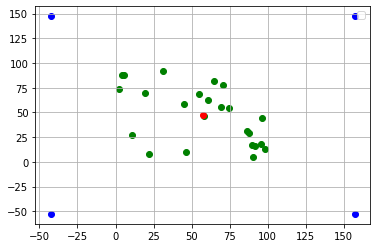

In [5]:
import matplotlib.pyplot as plt
import matplotlib.tri
import matplotlib.collections

fig, ax = plt.subplots()
ax.scatter(seeds[:,0], seeds[:,1], c="green")
ax.scatter(np.array(coords)[:,0], np.array(coords)[:,1], c="blue")
ax.scatter(center[0], center[1], c="red")

ax.legend()
ax.grid(True)

plt.show()

In [6]:
def circumcenter( tri):
        """Compute circumcenter and circumradius of a triangle in 2D.
        Uses an extension of the method described here:
        http://www.ics.uci.edu/~eppstein/junkyard/circumcenter.html
        """
        pts = np.asarray([coords[v] for v in tri])
        pts2 = np.dot(pts, pts.T)
        A = np.bmat([[2 * pts2, [[1],
                                 [1],
                                 [1]]],
                      [[[1, 1, 1, 0]]]])

        b = np.hstack((np.sum(pts * pts, axis=1), [1]))
        x = np.linalg.solve(A, b)
        bary_coords = x[:-1]
        center = np.dot(bary_coords, pts)

        # radius = np.linalg.norm(pts[0] - center) # euclidean distance
        radius = np.sum(np.square(pts[0] - center))  # squared distance
        return (center, radius)

In [7]:
# Create two dicts to store triangle neighbours and circumcircles.
triangles = {}
circles = {}

# Create two CCW triangles for the frame
T1 = (0, 1, 3)
T2 = (2, 3, 1)
triangles[T1] = [T2, None, None]
triangles[T2] = [T1, None, None]


In [8]:
def inCircleFast( tri, p):
        """Check if point p is inside of precomputed circumcircle of tri.
        """
        center, radius = circles[tri]
        return np.sum(np.square(center - p)) <= radius

In [9]:
# Compute circumcenters and circumradius for each triangle
for t in triangles:
            circles[t] = circumcenter(t)

In [10]:
def addPoint(p):
        """Add a point to the current DT, and refine it using Bowyer-Watson.
        """
        p = np.asarray(p)
        idx = len(coords)
        # print("coords[", idx,"] ->",p)
        coords.append(p)
        # Search the triangle(s) whose circumcircle contains p
        bad_triangles = []
        for T in triangles:
            # Choose one method: inCircleRobust(T, p) or inCircleFast(T, p)
            if inCircleFast(T, p):
                bad_triangles.append(T)

        # Find the CCW boundary (star shape) of the bad triangles,
        # expressed as a list of edges (point pairs) and the opposite
        # triangle to each edge.
        boundary = []
        # Choose a "random" triangle and edge
        T = bad_triangles[0]
        edge = 0
        # get the opposite triangle of this edge
        while True:
            # Check if edge of triangle T is on the boundary...
            # if opposite triangle of this edge is external to the list
            tri_op = triangles[T][edge]
            if tri_op not in bad_triangles:
                # Insert edge and external triangle into boundary list
                boundary.append((T[(edge+1) % 3], T[(edge-1) % 3], tri_op))

                # Move to next CCW edge in this triangle
                edge = (edge + 1) % 3

                # Check if boundary is a closed loop
                if boundary[0][0] == boundary[-1][1]:
                    break
            else:
                # Move to next CCW edge in opposite triangle
                edge = (triangles[tri_op].index(T) + 1) % 3
                T = tri_op

        # Remove triangles too near of point p of our solution
        for T in bad_triangles:
            del triangles[T]
            del circles[T]

        # Retriangle the hole left by bad_triangles
        new_triangles = []
        for (e0, e1, tri_op) in boundary:
            # Create a new triangle using point p and edge extremes
            T = (idx, e0, e1)

            # Store circumcenter and circumradius of the triangle
            circles[T] = circumcenter(T)

            # Set opposite triangle of the edge as neighbour of T
            triangles[T] = [tri_op, None, None]

            # Try to set T as neighbour of the opposite triangle
            if tri_op:
                # search the neighbour of tri_op that use edge (e1, e0)
                for i, neigh in enumerate(triangles[tri_op]):
                    if neigh:
                        if e1 in neigh and e0 in neigh:
                            # change link to use our new triangle
                            triangles[tri_op][i] = T

            # Add triangle to a temporal list
            new_triangles.append(T)

        # Link the new triangles each another
        N = len(new_triangles)
        for i, T in enumerate(new_triangles):
            triangles[T][1] = new_triangles[(i+1) % N]   # next
            triangles[T][2] = new_triangles[(i-1) % N]   # previous

In [11]:
# Insert all seeds one by one
for s in seeds:
        addPoint(s)


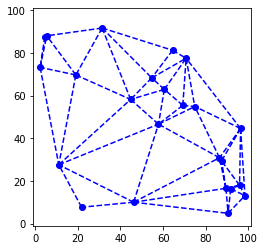

In [12]:

# Create a plot with matplotlib.pyplot
fig, ax = plt.subplots()
ax.margins(0.1)
ax.set_aspect('equal')
plt.axis([-1, radius+1, -1, radius+1])

# Plot our Delaunay triangulation (plot in blue)
cx, cy = zip(*seeds)
dt_tris = [(a-4, b-4, c-4) for (a, b, c) in triangles if a > 3 and b > 3 and c > 3]
ax.triplot(matplotlib.tri.Triangulation(cx, cy, dt_tris), 'bo--')